# **AM 207**: Homework 4

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday April 7th, 2016**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW4.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW4.tar.gz or AM207_YOURNAME_HW4.zip


### Have Fun!
_ _ _ _ _

In [706]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

# Problem 1: Bayesian Models for Yelp Check-in Data

Below is a visualization of Yelp checkins on a portion of the Las-Vegas strip. The goal of this problem is to model an intensity surface on this map which is indicative of the propensity of an individual to check in at a particular location.
<img src="Rplot.jpeg">
Such an intensity surface is very valuable for example to decide what would be good places to open another casino or restaurant. 

The first hierarchical model will use a conjugate prior (and hence we can compute an analytical solution) and the second will use a non-conjugate set up with correlated priors.

### Data description
We have M grid squares of width $w=0.005$. The variable `checkins` contains M checkin values, one for each square. The variable `X` contains the coordinates of the center of each square. This data set is a subset of the map shown above.

In [707]:
#load checkins
checkins = np.genfromtxt('checkin_counts.csv', delimiter=',')
#load latitude and longitude values associated with each count value
X = np.genfromtxt('X.csv', delimiter=',')
#set M to the length of the checkins vector
M = checkins.size
#set grid width w to be .0005 latitude/longitude
w = .0005

### Conjugate Model
In the first model, we assume that a map (i.e., the Las Vegas strip) is discretized into $M$ grid squares of width $w$, and the checkins in cell $i$, denoted by $Y_i$, are distributed according to a $Pois(w^2\lambda_i)$ distribution. (That is, the check-ins follow a Poisson process conditioning on the $\lambda$, and $\lambda \in \mathbb{R}^M$ is the intensity surface we would like to infer.) Furthermore $\lambda_i$ is drawn from a conjugate $Gamma(\alpha, \beta)$ distribution. The $Y_i$ are conditionally independent on $\lambda_i$, and $\lambda_i$ is indepndent of $\lambda_j$ for $i \neq j$.

Derive the posterior distribution $p(\lambda_i|Y_i)$ for this model analytically as a function of hyperparameters $\alpha$ and $\beta$. Use the posterior mean as an estimate for $\lambda_i$, and then plot the posterior mean of $\lambda_i$ on a grid for varying values of $\alpha$ and $\beta$. Discuss if this model leads to a useful intensity surface, and how the usefulness of the result is influenced by the choice of $\alpha$ and $\beta$.

### Non-Conjugate Model
Now let's move on to a slightly more complicated model. Again assume that the grid is discretized into $M$ cells of the same area, and the checkins in cell $i$, denoted by $Y_i$, are distributed according to a $Pois(w^2\lambda_i)$ distribution. However there is a twist: we assume $\lambda_i$ is equivalent to $Exp[\alpha+Z_i]$ where $Z \in \mathbb{R}^{M}$ is drawn from a multivariate normal $MVN(0,\Sigma)$ distribution, where $\Sigma$ comes from a squared exponential kernel, and $\alpha$ is drawn according to a N(0,1) distribution. In this way, the $\lambda_i$ for distinct cells are no longer independent but are correlated.(If you'd like to delve deeper, this process is called a "Log-Gaussian Cox process".)

Describe what the meaning of $\alpha$ and $\Sigma$ is for this model. 

We model $\Sigma$ using a square exponential kernel such that the covariances decay exponentially quickly as points get further apart from each other. That is $$\Sigma_{ij} = Exp[-||X_i-X_j||_2^2/\phi]$$

Where $X_i$ and $X_j$ are the $ith$ and $jth$ rows of $X$ respectively. Describe in which way the choice of $\phi$ influences the kernel. By default, use $\phi = .00001$. 

To simplify your code, consider the prior parameters/latent variables ($\alpha$, $Z$) jointly as a vector in $\mathbb{R}^{M+1}$. Determine the covariance matrix for the multivariate normal prior on this vector and store it all together in a variable called Sigma. Give a short explanation why we can do this. 
When you implement the computation of $\Sigma$, small numerical instabilities can lead to a covariance matrix that is not positive-semidefinite. You can check this by attempting a Cholesky decomposition of $\Sigma$ with numpy. If it throws an error, you can add a small offset to the diagonal of the matrix to help with numerical stability. 

We will provide you with code for an elliptical slice sampler for this problem. This sampling method was directly devloped for problems like this and we will discuss it later in class. For now it is sufficient for you to use the code, without neccessarily understanding it. Use the provided sampler to estimate the posterior mean for this non-conjugate model. In addition implement the model also in PYMC or vanilla Metropolis Hastings, and compare the result. 

Finally discuss the differences in results from the conjugate and the non-conjugate model and which one you would prefer. 

### Helper functions

Here is some code that should be useful:

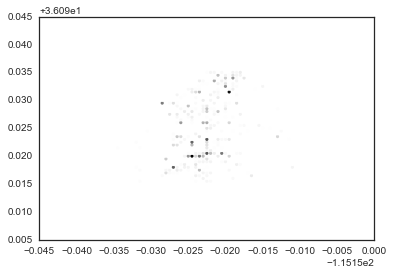

In [708]:
# This function takes a vector of M intensities and plots it according to the coordinates in `X`.
# The values of the intensities are normalized to [0,1] and darker means higher values
def plot_checkins(checkins):
    colors = checkins / np.double(np.max(checkins))
    plt.scatter(X[:,0], X[:,1], s=10, c=colors, cmap='gray_r', edgecolors='none')
    plt.show()
    
plot_checkins(checkins)

In [709]:
#elliptical slice sampler (Murray, Adams, and MacKay JMLR 2010)
# Inputs:
# Y: observed data
# Sig: covariance matrix of the prior
# log_lik: the log likelihood function
# N_mcmc: number of desired samples
# burn_in: number of burn in iterations
# N: dimensionality of the input, this should be M+1 because alpha is part of Sigma

# returns an array of samples of size N_mcmc x N

    
def ess(Y, Sig,log_lik, N_mcmc, burn_in, N):
    print 'running elliptical slice sampling...'
    mcmc_samples = np.zeros((N_mcmc+burn_in, N))
    norm_samples = np.random.multivariate_normal(np.zeros(N), Sig, N_mcmc+burn_in)
    unif_samples = np.random.uniform(0,1,N_mcmc+burn_in)
    theta = np.random.uniform(0,2*np.pi,N_mcmc+burn_in)
    theta_min = theta-2*np.pi
    theta_max = theta+2*np.pi
    for i in range(1,N_mcmc+burn_in):
        f = mcmc_samples[i-1,:]
        llh_thresh = log_lik(f,Y) + np.log(unif_samples[i])
        f_star = f*np.cos(theta[i])+norm_samples[i,:]*np.sin(theta[i])
        while log_lik(f_star,Y) < llh_thresh:
            if theta[i] < 0:
                theta_min[i] = theta[i]
            else:
                theta_max[i] = theta[i]
            theta[i] = np.random.uniform(theta_min[i],theta_max[i],1)  
            f_star = f*np.cos(theta[i])+norm_samples[i,:]*np.sin(theta[i]) 		
        mcmc_samples[i,:] = f_star
    return mcmc_samples[(burn_in+1):(burn_in+N_mcmc),]

### Conjugate model

#### Posterior distribution

$$p(\lambda_i|Y_i) \propto p(Y_i|\lambda_i)p(\lambda_i) = Pois(Y_i|w^2\lambda_i)Gamma(\lambda_i;\alpha, \beta)=Gamma(\alpha+Y_i,\beta+1)$$

Since Gamma is the conjugate prior, we know that the posterior is also a Gamma distribution with the hyperparameters $\alpha+Y_i$ and $\beta+1$.

The posterior mean = mean of $Gamma(\alpha+Y_i,\beta+1) = \frac{\alpha+Y_i}{\beta+1}$ 

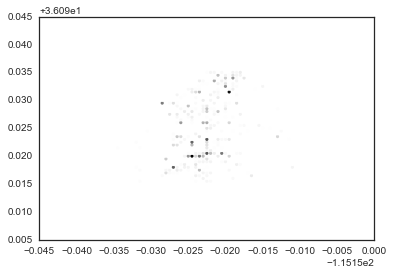

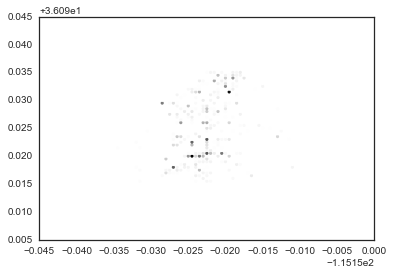

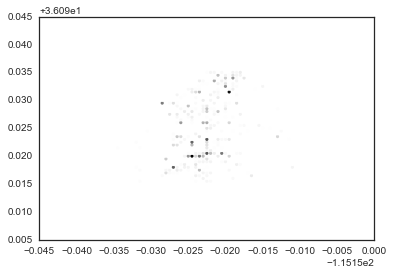

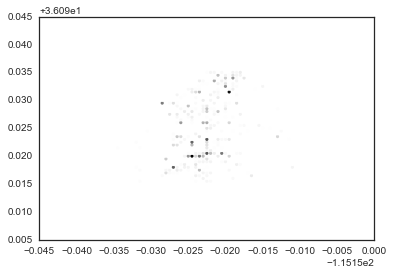

In [714]:
alpha = 0.1
beta = 0.1
means = (alpha + checkins)/(beta+1)
plot_checkins(means)

alpha = 1.0
beta = 1.0
means = (alpha + checkins)/(beta+1)
plot_checkins(means)

alpha = 10.0
beta = 10.0
means = (alpha + checkins)/(beta+1)
plot_checkins(means)

alpha = 100.0
beta = 100.0
means = (alpha + checkins)/(beta+1)
plot_checkins(means)

This model does not lead to a useful intensity surface because it is equivalent to simply plotting the number of checkins using the original data. From the formula of the posterior mean, we can see that $\alpha$ and $\beta$ shift and scale each $y_i$ by the same amount. Therefore, the relative intenstities of the different grid points remain the same. Hence, in the above plots, the intensity surfaces look identical for different values of $\alpha$ and $\beta$.

### Non-conjugate model

#### Meaning of $\alpha$ and $\Sigma$

$\alpha$ represents the 'base rate' of checkins that is modeled by a Normal(0,1) distribution. $\Sigma$ represents the covariance matrix which captures the 'closeness' of the points because it is modeled by the square exponential kernel. This means that points which are closer will have a higher covariance while points which are further apart have covariances that decreases exponentially as a function of the squared distance between the points. The value of the covariance will affect the $Z_i$ drawn from the multivariate Gaussian which affects $\alpha+Z_i$ which will then affect $\lambda_i$.

#### Choice of $\phi$

The choice of $\phi$ controls how fast the covariance decreases. Since $\phi$ is in the denominator, a value smaller than 1 will result in a large magnitude for $||X_i-X_j||_2^2/\phi$. Hence, $Exp[-||X_i-X_j||_2^2/\phi]$ will be a very small value. Therefore, even a small distance between 2 points will result in a small covariance. On the other hand, if the $\phi$ is a number larger than 1, it will cause $||X_i-X_j||_2^2/\phi$ to have a smaller magnitude. Hence, $Exp[-||X_i-X_j||_2^2/\phi]$ will be closer to 1. Therefore, points close to each other will have covariance of almost 1 and only points that are far apart will have a small covariance.

#### Covariance matrix for the multivariate normal prior

We can find a covariance matrix for the multivariate normal prior on the vector $(\alpha,Z)$ because both $\alpha$ and Z have normal distributions. We can simply augment $\Sigma$ from the multivariate normal distribution with another column and row for $\alpha$. Since $\alpha$ is independent of Z, the covariance between $\alpha$ and $Z_i$ is 0.

#### Likelihood

$$\prod_{i=1}^M Pois(Y_i|w^2\lambda_i) = \sum_{i=1}^M log\ Pois(Y_i|w^2\lambda_i)$$

#### Estimating posterior mean using ESS

In [715]:
# compute Sigma
phi = 0.00001
Sigma = np.zeros([M+1,M+1])
Sigma[0][0] = 1 # this is the variance of alpha

# calculate the covariance of Z
for i in range(1,M+1,1):
    for j in range(i,M+1,1):
        cov = np.exp(-(np.linalg.norm(X[i-1]-X[j-1]))**2/phi)
        if i != j:
            Sigma[i][j] = cov
            Sigma[j][i] = cov # because Sigma is symmetric
        else: 
            Sigma[i][j] = cov + 0.00001 # add small value to the diagonal to make matrix positive definite

In [716]:
np.linalg.cholesky(Sigma) # check to make sure Sigma is positive definite

array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   1.00000500e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   9.75305036e-01,   2.20884784e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   1.16880728e-41,   2.76613197e-40, ...,
          5.97911224e-03,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   1.79242402e-42,   4.50007055e-41, ...,
          6.58891723e-03,   6.50269942e-03,   0.00000000e+00],
       [  0.00000000e+00,   2.61471211e-43,   6.96027480e-42, ...,
          6.61284246e-03,   8.35538269e-03,   8.75953047e-03]])

In [717]:
# function to find log likelihood
def log_lik(f,Y):
    loglikelihood = 0
    for i in range(len(Y)):
        mu = w**2*np.exp(f[0] + f[i+1]) # f[0] is alpha, f[i+1] is z_i
        loglikelihood += scipy.stats.poisson.logpmf(Y[i], mu, loc=0)
    
    return loglikelihood

In [579]:
# sampling using ESS
N_mcmc = 1000 # 10000
burn_in = 200 # 1000
N = M+1
params = ess(checkins, Sigma,log_lik, N_mcmc, burn_in, N)

running elliptical slice sampling...


(array([  36.,   37.,   21.,   33.,   43.,   29.,   45.,   52.,   42.,  661.]),
 array([ 11.13509277,  11.86795138,  12.60080999,  13.33366861,
         14.06652722,  14.79938583,  15.53224445,  16.26510306,
         16.99796167,  17.73082029,  18.4636789 ]),
 <a list of 10 Patch objects>)

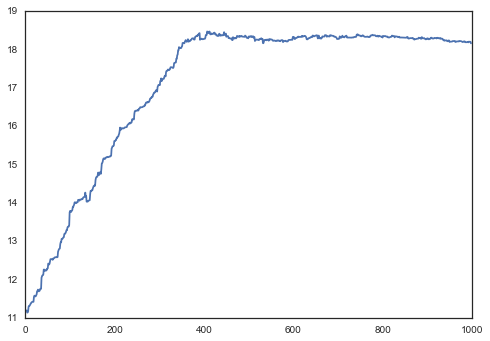

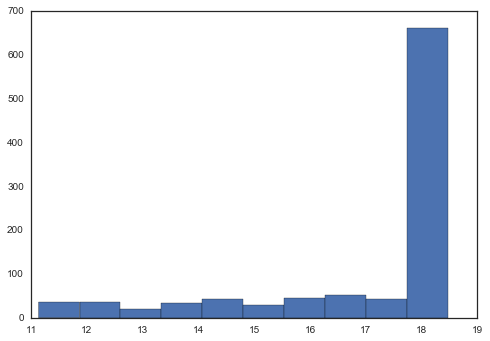

In [691]:
alpha_trace = []
for i in params:
    alpha_trace.append(i[0])
plt.plot(alpha_trace)    
plt.figure()
plt.hist(alpha_trace)

In [ ]:
# find lambda = alpha + zi
intensity = []
for i in params:
    

#### Estimating posterior mean using PYMC

In [721]:
a_Z = pm.MvNormalCov('params',mu=np.zeros(M+1),C=Sigma)

# create the likelihood
@pm.observed
def log_lik_pymc(parameters = a_Z,value = checkins):
    loglikelihood = 0
    for i in range(len(value)):
        rate = w**2*np.exp(parameters[0] + parameters[i+1]) # parameters[0] is alpha, parameters[i+1] is z_i
        loglikelihood += pm.poisson_like(value[i],mu=rate)
    
    return loglikelihood

params_pymc = [a_Z, log_lik_pymc] # include the parameters that need to be varied in the pymc run
model=pm.Model(params_pymc)
mcmc = pm.MCMC(model)
mcmc.sample(iter=10000, burn=1000,thin=5)

 [-----------------100%-----------------] 10001 of 10000 complete in 2314.3 sec

In [ ]:
alpha_trace = []
for i in params:
    alpha_trace.append(i[0])
plt.plot(alpha_trace)    
plt.figure()
plt.hist(alpha_trace)

compare the result.
Finally discuss the differences in results from the conjugate and the non-conjugate model and which one you would prefer.

# Problem 2: Point Matching

In this problem you are given two point clouds `points1` and `points2`. Your task is to estimate an affine transformation which can map the points of `points1` onto the points of `points2`. Unfortunately you don't know which points from the two point sets correspond to each other.

We are modeling the correspondences in a correspondence matrix $M$, which is of size $n_1 \times n_2$ where $n_i$ is the number of points in point set $i$. $M_{ij}=1$ indicates that point $x_i$ from `points1` and $y_j$ from `points2` correspond to each other. Each point is only allowed to have one correspondence. So for all $i$ we have $\sum_l^{n_2} M_{il} = 1$ 

The likelihood for this problem is:

$$ \prod_i^{n_1} \prod_j^{n_2} \varphi_{0,\sigma}\left(||Ax_i - y_j||^2\right)^{M_{ij}} $$

where $\varphi_{0,\sigma}$ is a normal distribution with mean 0 and variance $\sigma^2$. We use $\sigma^2 = 0.1$ as a default for this problem. 

Estimate the affine transform $A$ that matches the two point sets using expectation maximization and simulated annealing and compare the results. What are the strength of each algorithm? Which one would you prefer in which scenario?

Here are some hints that should be useful:
* The M-step of the problem will be a weighted least squares solution. 
* To use linear algebra to solve the M step it is useful to extend the point matrices to contain all possible pairwise correspondence pairs. 
* The weights for the weighted least squares should be updated in your E-step

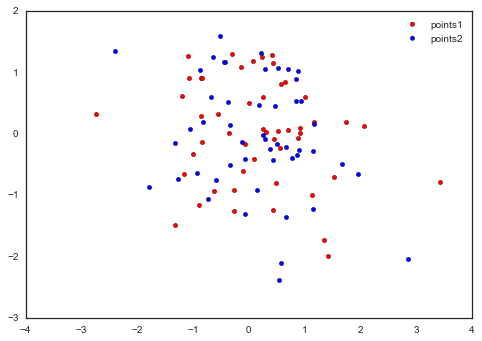

In [6]:
points1 = np.array([[-0.855,  0.905,  1.   ],[ 1.417, -1.999,  1.   ],[-0.896, -1.166,  1.   ],[-0.114, -0.604,  1.   ],
                    [ 2.055,  0.131,  1.   ],[ 0.694,  0.056,  1.   ],[-1.318, -1.495,  1.   ],[ 0.479, -0.799,  1.   ],
                    [-1.081,  0.91 ,  1.   ],[-0.273, -1.258,  1.   ],[ 1.733,  0.188,  1.   ],[ 0.65 ,  0.848,  1.   ],
                    [-0.007,  0.507,  1.   ],[-0.262, -0.922,  1.   ],[-0.14 ,  1.078,  1.   ],[ 0.239,  1.246,  1.   ],
                    [ 0.528,  0.036,  1.   ],[ 0.31 ,  0.025,  1.   ],[-2.734,  0.325,  1.   ],[ 1.014,  0.597,  1.   ],
                    [-0.839, -0.137,  1.   ],[ 0.924,  0.012,  1.   ],[ 0.09 , -0.407,  1.   ],[ 0.433, -1.236,  1.   ],
                    [ 1.345, -1.731,  1.   ],[-0.362,  0.012,  1.   ],[ 0.416,  1.279,  1.   ],[ 1.165,  0.185,  1.   ],
                    [ 0.446, -0.088,  1.   ],[-1.006, -0.335,  1.   ],[ 0.072,  1.188,  1.   ],[ 0.25 ,  0.076,  1.   ],
                    [ 1.525, -0.699,  1.   ],[ 0.574,  0.805,  1.   ],[-1.171, -0.655,  1.   ],[ 0.873, -0.067,  1.   ],
                    [-0.306,  1.291,  1.   ],[-0.07 , -0.174,  1.   ],[-1.088,  1.27 ,  1.   ],[-0.864,  0.295,  1.   ],
                    [-0.845,  0.914,  1.   ],[ 1.136, -1.001,  1.   ],[-0.55 ,  0.328,  1.   ],[-1.201,  0.621,  1.   ],
                    [-0.617, -0.941,  1.   ],[ 0.438,  1.147,  1.   ],[ 0.252,  0.593,  1.   ],[ 3.42 , -0.792,  1.   ],
                    [ 0.923,  0.096,  1.   ],[ 0.563, -0.235,  1.   ]])

points2 = np.array([[-0.131, -0.134,  1.   ],[-2.402,  1.347,  1.   ],[ 0.137, -0.921,  1.   ],[ 0.581, -2.113,  1.   ],
                    [ 0.283,  1.049,  1.   ],[-0.734, -1.058,  1.   ],[ 0.26 , -0.025,  1.   ],[ 0.296, -0.095,  1.   ],
                    [ 0.211,  1.31 ,  1.   ],[ 0.874,  1.023,  1.   ],[-0.336, -0.515,  1.   ],[ 0.859, -0.343,  1.   ],
                    [-0.073, -1.308,  1.   ],[-1.058,  0.075,  1.   ],[ 0.544, -2.389,  1.   ],[-0.827,  0.195,  1.   ],
                    [ 0.666, -1.36 ,  1.   ],[ 0.698,  1.059,  1.   ],[-1.274, -0.734,  1.   ],[-0.52 ,  1.589,  1.   ],
                    [ 1.141, -1.229,  1.   ],[ 0.89 , -0.265,  1.   ],[ 0.521,  1.07 ,  1.   ],[-0.651,  1.254,  1.   ],
                    [-0.686,  0.603,  1.   ],[ 0.502, -0.169,  1.   ],[ 0.925,  0.535,  1.   ],[-0.93 , -0.634,  1.   ],
                    [-0.33 ,  0.149,  1.   ],[-0.431,  1.168,  1.   ],[ 0.43 , -0.433,  1.   ],[ 1.949, -0.665,  1.   ],
                    [-0.872,  1.033,  1.   ],[ 0.378, -0.252,  1.   ],[-1.79 , -0.877,  1.   ],[ 0.781, -0.396,  1.   ],
                    [ 1.147, -0.275,  1.   ],[-0.073, -0.41 ,  1.   ],[ 1.673, -0.489,  1.   ],[-1.332, -0.157,  1.   ],
                    [-0.444,  1.163,  1.   ],[ 0.459,  0.452,  1.   ],[ 0.843,  0.892,  1.   ],[ 0.662, -0.214,  1.   ],
                    [ 0.838,  0.524,  1.   ],[ 0.188,  0.471,  1.   ],[ 1.166,  0.164,  1.   ],[-0.595, -0.751,  1.   ],
                    [-0.382,  0.514,  1.   ],[ 2.857, -2.04 ,  1.   ]])

plt.scatter(points1[:,0], points1[:,1], c='r', label='points1')
plt.scatter(points2[:,0], points2[:,1], c='b', label='points2')
plt.legend()
plt.show()

#### Expectation-Maximization

In the E step, we are trying to update the weight / probability that $x_i$ corresponds to $y_i$ given the current estimate of A. We can do this by calculating the posterior, and the formula for updating the weight is:

$$w_{i,j}= p(z_i=y_j| x_i, A) = \frac{p( x_i| z_i=y_j, A)\, p(z_i=y_j)}{\sum_{l=1}^k p(x_i | z_i=y_l,A) \, p(z_i=y_l)}$$

In this question, we can treat each $y_i$ as the label for the $x_i$. The first term in the numerator is thus interpreted as the probability of $x_i$ given that the label is $y_j$. The second term in the numerator is interpreted as the probability that the label is $y_j$. 

In the M step, we update the A matrix by finding the weighted least square solution which is given by:

$$A = (X^TWX)^{-1}X^TWY$$

where W is a n^2 by n^2 matrix with the diagonal entries representing the probability that $x_i$ corresponds to $y_j$.

In [722]:
numpoints = len(points1)
# create the extended point matrices
x = np.tile(points1[0],[numpoints,1])
for i in points1[1:]:
    x = np.append(x, np.tile(i,[numpoints,1]), 0)

y = np.tile(points2, [numpoints,1])

In [723]:
# E step

def Estep(x, W, A, y):
    mu = 0
    std = np.sqrt(0.01)
    # W is a n**2 by n**2 diagonal matrix. Each entry of the diagonal represents the probability 
    # that x_i corresponds to y_j
    updated_W = W.copy() 
    for i in range(numpoints):
        numerators = []
        tmp = np.linalg.norm(np.tile(np.dot(x[i],A),[numpoints,1])-y,axis=1) # calculate ||Ax-y||**2 for each (x,y) combination
        p1 = scipy.stats.norm.pdf(tmp, loc=mu, scale=std) # calculate the likelihood
        p2 = np.diag(W)[i*numpoints:i*numpoints+numpoints] # probability of label = y_j for point x_i
        new_weights = (p1*p2)/np.sum(p1*p2) # based on the formula presented above
 
        for j in range(numpoints):
            updated_W[i*numpoints+j][i*numpoints+j] = new_weights[j] # update the weights
        
    return updated_W

In [724]:
# M step

def Mstep(x, W, y):
    A = np.dot(np.dot(np.dot(np.linalg.inv(np.dot(np.dot(x.T,W),x)),x.T),W),y) # weighted least square solution
    return A

In [731]:
# Initialize values

# these initialization values were chosen based on the A that I got from simulated annealing. 
tmp1 = 0.8 + 0.2*np.random.random(1) 
tmp2 = 0.3 + 0.2*np.random.random(1)
A = [[  tmp1,  -tmp2,   0],[tmp2,  tmp1,  0], [ 0,  0,   1]]
W = np.diag(1.0/numpoints*np.ones(numpoints**2))

# Stopping criterion
crit = 1e-10

# Convergence flag
converged = False

# Loop until converged
iterations=1

tic = time.time()
while not converged:
    # E-step
    W = Estep(points1, W, A, points2)
    
    # M-step
    A_new = Mstep(x, W, y)
    
    # Check convergence
    converged = (np.abs(A_new - A) < crit).all()
    A = A_new
    
    iterations +=1  
    
print "Iterations", iterations

Iterations 945


In [735]:
print ('This is the affine transformation matrix A: ')
A

This is the affine transformation matrix: 


array([[  9.23982715e-01,  -3.82589432e-01,   5.37764278e-17],
       [  3.82610196e-01,   9.23838366e-01,  -5.03069808e-17],
       [ -4.90857459e-05,  -4.89204518e-06,   1.00000000e+00]])

In [747]:
tmpM = np.diag(W)
tmpM = (tmpM > 0.95).astype(int)

print ('This is the M matrix: ')
for i in range(numpoints):
    print tmpM[i*numpoints:i*numpoints+numpoints]

This is the M matrix: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

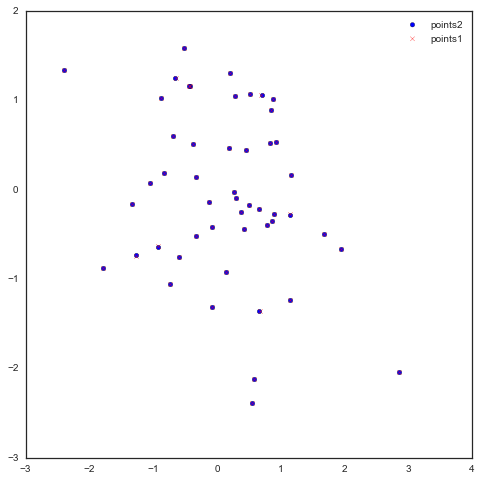

In [752]:
transformedpoints_EM = np.dot(points1,A)
plt.figure(figsize=[8,8])
plt.scatter(points2[:,0], points2[:,1], c='b', label='points2')
plt.scatter(transformedpoints_EM[:,0], transformedpoints_EM[:,1], c='r', marker="x", label='points1')
plt.legend()
plt.show()

From the plot above, we can see that the estimated A matrix transforms points1 to points2 because the transformed points1 (denoted by 'x') lie on top of the corresponding points2 (denoted by 'o').

#### Simulated annealing

In [403]:
# swap the n_swaps points randomly
def changepoints(inputX, n_swaps):
    
    x = inputX.copy()
    for i in range(n_swaps):
        swappedX = swapindex(x)
        x = swappedX.copy()

    return x

def swapindex(x):
    
    indices = range(len(x))
    # take two random indices to swap
    i1 = np.random.choice(indices)
    i2 = np.random.choice(indices)
    
    while i2 == i1:
        i2 = np.random.choice(indices) 
    
    # remember the points to swap
    tmp1 = x[i1,:]
    tmp2 = x[i2,:]
    
    # do the actual swapping
    changedX = x.copy()
    changedX[i1,:] = tmp2
    changedX[i2,:] = tmp1
    
    return changedX

The least square formula is:

$$A = (X^TX)^{-1}X^TY$$

In [404]:
# function to find the value of the least squares given a particular correspondence between the 2 sets of points
def getValue(x,y):
    A = np.dot(np.dot(np.linalg.inv(np.dot(x.T,x)),x.T),y)
    LSvalue = 0
    for i in range(len(x)):
        LSvalue += np.sqrt(np.linalg.norm(np.dot(x[i],A)-y[i])) # taking the square root of the norm seems to allow the simulation to converge better
        
    return LSvalue, A

In [405]:
def simulated_annealing(x, y, init_temp, thermostat, ftol, itol, reannealing):
    m=1000    #for function tolerance
    value=[]    #keep track of the least square solution
    temperature = init_temp 
    N = 2 # proportionality constant for fast annealing
    
    # number of accepted steps
    it = 0                    

    # initial value
    prev_value, A = getValue(x,y)  
    
    # number of iterations
    niter=0

    while it >= 0:
        # Fast annealing: L is the number of points to swap 
        L = np.max((np.floor(N*temperature).astype(int),1))

        # Swap order of points1 to get a new correspondence between points1 and points2
        propose_x = changepoints(x, L)

        new_value, A = getValue(propose_x,y)
        deltaValue  =  new_value - prev_value
        
        # if new value < prev value, always accept proposed points
        if new_value < prev_value:
            x = propose_x
            value.append(new_value)
            prev_value = new_value
            if new_value == np.min(value):
                bestA = A
                bestX = propose_x
            it = it+1
        
        # else, accept with some probability dependent on temperature
        elif np.random.rand() < np.exp(-deltaValue/temperature):
            x = propose_x
            value.append(new_value)
            prev_value = new_value  
            it = it+1

        niter = niter + 1
          
        # reannealing step using linear schedule
        if it % reannealing == 0:
            temperature = thermostat * temperature;
            
            #if we get too cold, reheat
            if temperature < 0.01:
                temperature = 1.0
        
        # stopping criteria
        # function tolerance
        if len(value) > m and np.std(value[-m:])/np.mean(value[-m:]) < ftol:
            print 'ftol'
            break
        # maximum num of iterations reached
        if niter > itol:
            print 'itol'
            break
    
    return bestX, value, bestA

itol
Number of accepted steps:  9358
Minimum value of least squares solution:  1.10790102338


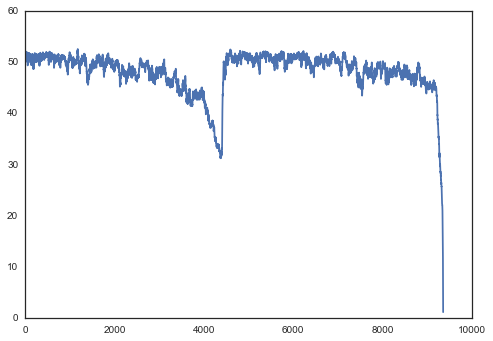

In [411]:
# initialise with random order of points1
rand_ind = np.random.permutation(len(points1))
x = np.array([points1[i] for i in rand_ind])

orderedX, values, A = simulated_annealing(x, points2, 1.0, 0.9, 0.01, 30000, 400)

print ('Number of accepted steps: '), len(values)
print ('Minimum value of least squares solution: '), np.min(values)
plt.plot(values)

M: 
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]]

A: 
[[  9.23982723e-01  -3.82589429e-01   4.51028104e-17]
 [  3.82610186e-01   9.23838363e-01  -3.98986399e-17]
 [ -4.90965656e-05  -4.89620663e-06   1.00000000e+00]]


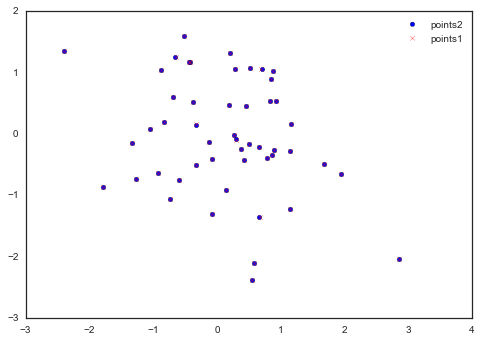

In [412]:
print ('This is the affine transformation matrix A: ')
print A

M = np.zeros([len(points1),len(points1)])
i = 0

for g in orderedX:
    j = 0
    for k in points1:
        if (g == k).all():
            M[i][j] = 1
        j += 1
    i += 1
print ('This is the M matrix: ')
for i in range(numpoints):
    print tmpM[i*numpoints:i*numpoints+numpoints]
    
orderedPoints1 = np.dot(orderedX,A)
plt.scatter(points2[:,0], points2[:,1], c='b', label='points2')
plt.scatter(orderedPoints1[:,0], orderedPoints1[:,1], c='r', marker="x", label='points1')
plt.legend()
plt.show()

From the plot above, we can see that the estimated A matrix transforms points1 to points2 because the transformed points1 (denoted by 'x') lie on top of the corresponding points2 (denoted by 'o'). 

compare the results. What are the strength of each algorithm? Which one would you prefer in which scenario?


# Problem 3 Time Series

Below you find 200 data points from a time series. Your task is to model this data using a simple autoregressive model:

$$
X_t=\alpha X_{t-1}+r_t
$$
where $r_t$ is normally distributed: $r_t \sim\mathcal{N}(0,\sigma^2)$

Here are your tasks:
* Implement a maximum likelihood estimation(MLE) method to estimate $\alpha$
* Use any MCMC algorithm of your choice to infere $\sigma^2$ and $\alpha$
* Forecast 3 time points ahead and provide posteriors for these three points

In [604]:
# Here is the data
y=np.array([0.00000000e+00,  -2.41884381e-01,  -2.19815584e-01, -5.92654275e-03,   3.89498469e-02,  -7.06374756e-01,
         6.09244734e-02,  -1.36663360e+00,  -1.63887006e+00, -1.31721354e+00,  -1.52424274e+00,  -1.23902096e+00,
        -6.63029664e-01,  -5.97693396e-01,   1.26359198e-01, 6.55116724e-01,   2.98253859e-01,   7.19461104e-03,
         4.04113046e-01,   7.29893878e-01,  -1.96731327e-03, 4.64230686e-01,  -6.79727540e-02,  -4.19137503e-01,
        -4.03256074e-01,  -8.70131096e-01,  -8.25921060e-01, 4.69417714e-01,  -1.00177377e-01,   6.34076840e-02,
        -1.05978178e-01,  -1.48916430e-01,  -5.43573786e-02, 4.61970441e-01,   8.18280558e-01,   2.87185308e-01,
         1.26715777e+00,   6.41828280e-01,   8.77364512e-01, 3.67214345e-01,   6.26413729e-01,   2.87102039e-02,
         4.28449069e-01,   7.31450267e-01,   6.19131504e-01, 6.33373751e-01,   3.17572088e-01,   3.51692600e-01,
        -2.48995087e-02,  -2.53030153e-01,  -2.15503832e-01,-6.20238803e-01,  -5.28176551e-01,  -5.99112522e-01,
         3.32834574e-01,   4.01426008e-01,  -6.37956657e-01,-4.52884655e-01,  -1.16203988e+00,  -8.82257305e-01,
        -6.19309194e-01,  -4.78009274e-01,  -2.32960888e-01, 3.80860392e-01,  -5.52337194e-01,   6.43589528e-01,
        -1.71939822e-01,  -2.22714248e-02,   1.69698173e-01, 2.26875861e-01,   6.27784254e-02,   9.59070565e-01,
        -2.00412521e-01,   1.62853318e-02,  -1.64492388e-02,-5.92514844e-01,  -1.43386816e-01,  -9.50829381e-01,
        -1.07109089e+00,  -5.47941202e-01,  -6.80501959e-01,-1.22073393e+00,  -5.09858830e-01,  -1.24176275e+00,
        -6.30383282e-01,  -8.67182207e-01,  -9.67761290e-01,-1.79674059e-01,   6.09919157e-01,   9.95635469e-02,
         2.28199545e-01,   4.21792446e-01,   1.69467875e-01,-2.59645693e-01,  -4.93207819e-01,  -5.01539736e-01,
        -6.05873935e-01,  -6.11037064e-01,   1.01647103e-01,-1.44991643e-01,  -4.33238432e-02,  -6.41062073e-02,
        -2.85514261e-01,  -3.95586179e-01,  -3.57194799e-01,-2.20170569e-01,  -3.39918202e-01,   1.70035788e-01,
         7.41558107e-01,   8.33120964e-01,   3.73995334e-01, 4.83141624e-01,  -1.28861162e-01,  -4.22192149e-01,
         5.78378631e-01,   1.43550174e-01,  -1.31226657e-01,-5.30885377e-01,  -8.76270272e-01,  -4.34154230e-01,
        -5.02379201e-01,  -5.14585915e-01,  -4.64397849e-01, 1.65475660e-01,   1.07774616e-01,  -9.65587168e-01,
        -8.60566293e-01,  -2.36405434e-01,  -4.12606502e-01,-5.58566210e-01,   1.20028400e+00,   9.96896069e-01,
         4.41653164e-01,   1.59249052e-01,  -1.74168536e-01, 5.63049814e-01,   7.39366310e-01,   6.05361272e-01,
         2.79509214e-01,  -6.26883609e-01,  -4.44982987e-01,-8.69359696e-01,  -9.27422224e-01,  -6.98179880e-01,
        -1.35445853e+00,  -1.12329955e+00,  -4.94572306e-01,-3.40507834e-01,  -8.37907253e-01,  -9.97003760e-01,
        -7.69088724e-01,  -4.77378429e-01,   4.52315984e-02, 8.76114754e-02,  -9.24336169e-02,   4.42178858e-01,
         6.32190755e-01,   8.18383124e-01,   2.95975304e-01,-2.38797237e-02,   1.16395924e-01,   5.62311884e-02,
        -3.15966789e-01,  -3.16808474e-01,  -1.16651970e+00,-1.01729199e+00,  -7.75285712e-01,  -4.17618624e-01,
        -7.65156825e-01,  -5.10469718e-01,  -3.25334859e-01, 1.06358791e-01,   4.03467712e-01,   5.62837155e-01,
         5.87793605e-01,   4.38191557e-01,  -4.17879322e-01,-3.19715350e-01,   3.41624528e-01,   4.93054502e-01,
         3.69746949e-01,   9.62398763e-02,  -2.81485049e-01,-3.37776564e-01,  -1.30858217e-03,   9.83538405e-01,
         6.94986165e-01,   2.41137851e-01,   2.79478944e-01, 5.13500357e-01,   4.17786188e-01,   7.46707509e-01,
         1.25038407e+00,   8.17699739e-01,   8.78811468e-02,-1.20413802e-01,  -1.83227208e-01,   8.06195706e-02,
         4.16043086e-01,   6.45585187e-02])


#### MLE to estimate $\alpha$

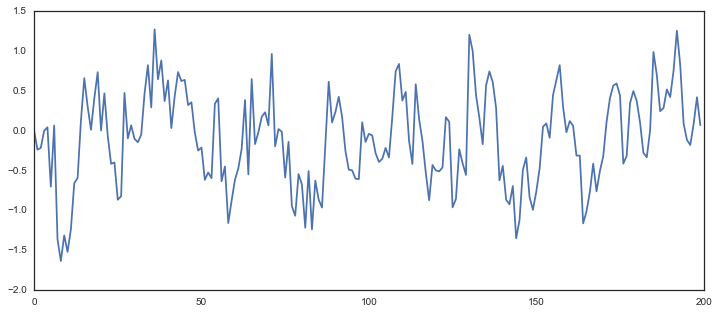

In [638]:
plt.figure(figsize=[12,5])
plt.plot(y)

Looking at the time series, the process is likely to be stationary because we can see that the series does not move very far from the original value. (If the statsmodels library was imported then we could check the autocorrelation function to see if the autocorrelation dies off. However, we are not supposed to import additional libraries, hence I did not plot the autocorrelation.)

First, we have to find the likelihood function. Since the $X_t$ are not independent, we cannot just multiply the marginal probability distributions together. Instead, we have to use the product rule to express the likelihood:

$$P(x_1, x_2,...,x_N|\alpha,\sigma^2) = \prod_{n=1}^{N} P(x_n | x_1 , x_2 , ... , x_{n-1};\alpha,\sigma^2 ) = \prod_{n=1}^{N} P(x_n | x_{n-1};\alpha,\sigma^2 )$$ 

since $X_n$ only depends on $X_{n-1}$.

$X_1$ is normally distributed since $r_t$ is normally distributed. From the lecture notes, we know that for the AR(1) model with $|\alpha| < 1$, E[$X_1$] = 0 and var($X_1$) = $\frac{\sigma^2}{1-\alpha^2}$. Therefore, 

$$X_1 \sim N(0, \frac{\sigma^2}{1-\alpha^2})$$

$$P(x_1;\alpha,\sigma^2) = \frac{1}{\sqrt{2\pi\frac{\sigma^2}{1-\alpha^2}}}exp\left(-\frac{x_1^2}{\frac{2\sigma^2}{1-\alpha^2}}\right)$$

Next, we find $P(x_2|x_1)$. Given $X_1$, $X_2$ is normally distributed with mean = $\alpha X_1$ and variance = $\sigma^2$. Therefore, 

$$(X_2|X_1=x_1) \sim N(\alpha x_1, \sigma^2)$$

$$P(x_2|x_1;\alpha,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}exp\left(-\frac{(x_2-\alpha x_1)^2}{2\sigma^2}\right)$$


In general $P(x_n | x_1 , x_2 , ... , x_{n-1} ) = P(x_n | x_{n-1} )$ since $X_n$ only depends on $X_{n-1}$. Hence, given the previous values in the time series, $X_n$ is normally distributed with mean = $\alpha X_{n-1}$ and variance = $\sigma^2$. Therefore, 

$$P(x_n | x_{n-1};\alpha,\sigma^2 ) = \frac{1}{\sqrt{2\pi\sigma^2}}exp\left(-\frac{(x_n-\alpha x_{n-1})^2}{2\sigma^2}\right)$$

The likelihood function is

$$P(x_1, x_2,...,x_N|\alpha,\sigma^2) = \prod_{n=1}^{N} P(x_n | x_{n-1};\alpha,\sigma^2 ) = \frac{1}{\sqrt{2\pi\frac{\sigma^2}{1-\alpha^2}}}exp\left(-\frac{x_1^2}{\frac{2\sigma^2}{1-\alpha^2}}\right) \prod_{i=2}^N \frac{1}{\sqrt{2\pi\sigma^2}}exp\left(-\frac{(x_i-\alpha x_{i-1})^2}{2\sigma^2}\right)$$

The log likelihood function is 

$$L = log\ P(x_1, x_2,...,x_N|\alpha,\sigma^2) = -\frac{1}{2}log\ (2\pi\sigma^2) +\frac{1}{2}log\ (1-\alpha^2) -\frac{x_1^2}{\frac{2\sigma^2}{1-\alpha^2}} - \frac{N-1}{2}log\ (2\pi\sigma^2) - \sum_{i=2}^N\frac{(x_i-\alpha x_{i-1})^2}{2\sigma^2}$$

$$ \frac{\partial L}{\partial \alpha} = -\frac{\alpha}{1-\alpha^2} + \frac{x_1^2}{2\sigma^2}(2\alpha) + \sum_{i=2}^N \frac{x_i-\alpha x_{i-1}}{\sigma^2}(x_{i-1})
= -\frac{\alpha}{1-\alpha^2} + \frac{x_1^2}{\sigma^2}\alpha + \sum_{i=2}^N \frac{x_i(x_{i-1})}{\sigma^2}
- \alpha\sum_{i=2}^N \frac{(x_{i-1})^2}{\sigma^2} = 0$$

#### Using pymc to find $\alpha$ and $\sigma^2$

In [617]:
# prior
alpha = pm.Uniform('alpha',0.0,1.0) # alpha should be between 0 and 1 
sigma2 = pm.Uniform('sigma2',0.0,1.0)

# create the likelihood
@pm.observed
def get_likelihood(value=y, alpha=alpha, var=sigma2):
    likelihood = 0
    for i in range(len(value)):
        if i == 0:
            likelihood += pm.normal_like(value[i],0,(1-alpha**2)/var) #this is for p(x1)
        else:
            likelihood += pm.normal_like(value[i],alpha*value[i-1],1.0/var) # this is for p(x_n|x_{n-1})
            
    return likelihood

model_timeseries=pm.Model([alpha, sigma2, get_likelihood])
mcmc_timeseries = pm.MCMC(model_timeseries)
mcmc_timeseries.sample(iter=20000, burn=2000,thin=5)

 [-----------------100%-----------------] 20000 of 20000 complete in 98.7 sec

Plotting alpha


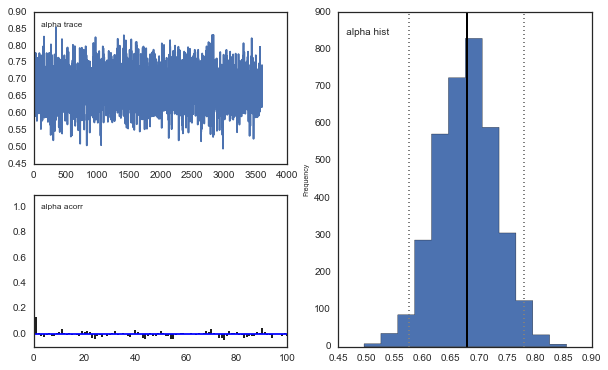

In [621]:
pm.Matplot.plot(alpha)

MAP for alpha:  0.684490994298


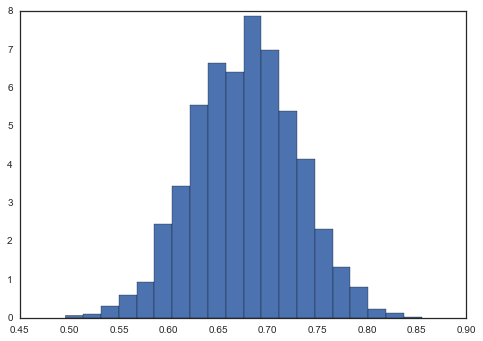

In [623]:
# find the MAP
alpha_hist = plt.hist(alpha.trace(), bins=20, normed=True)
map_index_alpha = np.argmax(alpha_hist[0]) #index of the largest value in the histogram
hist_bin_middle_alpha = 0.5*alpha_hist[1][:-1] + 0.5*alpha_hist[1][1:] #value of the bin middle
alpha_map = hist_bin_middle_alpha[map_index_alpha]
print "MAP for alpha: ", alpha_map

Plotting sigma2


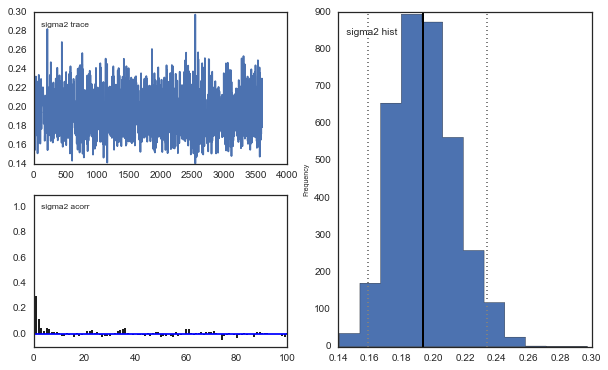

In [619]:
pm.Matplot.plot(sigma2)

MAP for sigma2:  0.191566346514


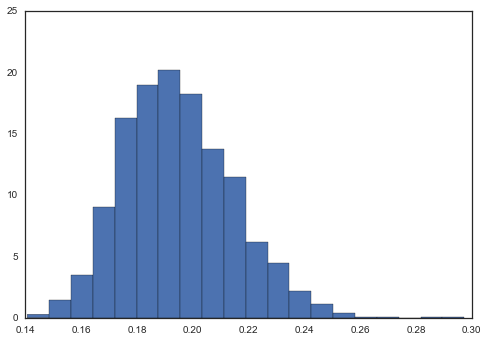

In [624]:
# find the MAP
sigma2_hist = plt.hist(sigma2.trace(), bins=20, normed=True)
map_index_sigma2 = np.argmax(sigma2_hist[0]) #index of the largest value in the histogram
hist_bin_middle_sigma2 = 0.5*sigma2_hist[1][:-1] + 0.5*sigma2_hist[1][1:] #value of the bin middle
sigma2_map = hist_bin_middle_sigma2[map_index_sigma2]
print "MAP for sigma2: ", sigma2_map

The estimated $\alpha$ is 0.684 and $\sigma^2$ is 0.192. Using these values, a time series was generated starting at y[0]. It can be seen that the generated time series has a similar trend when compared to the original time series. Therefore, the estimated values of $\alpha$ and $\sigma^2$ should be close to the actual values.

In [633]:
def ts_gen_ar1(start, size, sigma, alpha1, c):
    e=np.random.normal(0,sigma,size)
    x=np.zeros(size)
    x[0] = start
    for i in np.arange(1,size,1):
        x[i] = c+alpha1*x[i-1] + e[i]
    return x

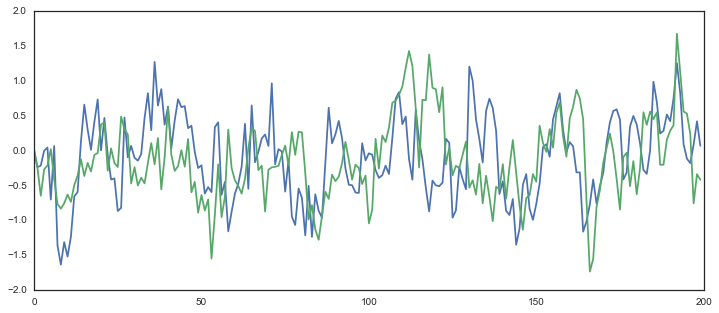

In [652]:
plt.figure(figsize=[12,5])
plt.plot(y)
ts1 = ts_gen_ar1(y[0], 200, np.sqrt(sigma2_map), alpha_map, 0)
plt.plot(ts1)

#### Forecast 3 time points ahead

In [653]:
# posterior predictive to determine whether the model is good
survey_data_sim = pm.Normal('likelihood',mu=mu,tau=1.0/data_var)
posterior_predictive_model_survey = pm.Model([get_likelihood])
mcmc_posterior_complete = pm.MCMC(posterior_predictive_model_survey)
mcmc_posterior_complete.sample(iter=10000, burn=1000, thin = 2)
# pm.Matplot.gof_plot(survey_data_sim, data_means, name = 'survey_data')

 [-----------------100%-----------------] 10000 of 10000 complete in 0.1 sec

In [627]:
alpha.trace().shape

(3600,)

# Extra Problem 4: Final Project Proposal 

Think about your final project proposal. Your final project is your chance to show off what you learned in AM207! You have seen a lot of different models and examples in lecture and in the homework assignments. In your final project you are free to apply all the techniques you learned to an area of your choice. Be careful not to choose data that you still need to label yourself or that will take you ages to clean. The main focus should be on finding a good model and comparing different techniques for sampling, optimization, etc. 

Please note that there will be a google spreadsheet where you can submit your final project proposal abstract. No need to write it into this notebook. 

The abstract should be short, but contain a short description of your final project idea, which methods you are planning on using, and where your data will come from. 